In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/stochastic_simulations/julia`


In [2]:
using Catalyst
using JumpProcesses
using DifferentialEquations
using Statistics
using NPZ
using Distributions: Geometric
using Catalyst, Latexify, OrdinaryDiffEqTsit5, ModelingToolkit, Plots

In [3]:
using Distributions: Geometric
@register_symbolic Geometric(b)
@parameters b
r = rand(Geometric(1/b)) + 1

1 + rand(Geometric(1 / b))

In [4]:
bursty_model = @reaction_network bursty_model begin
    k, G --> G + $r*P
    d, P --> 0 
    end

Model bursty_model:
Unknowns (2): see unknowns(bursty_model)
  G(t)
  P(t)
Parameters (3): see parameters(bursty_model)
  k
  d
  b

In [5]:
reactions(bursty_model)

2-element Vector{Reaction}:
 k, G --> G + (1 + rand(Geometric(1 / b)))*P
 d, P --> ∅

In [6]:
bursty_jsys = convert(JumpSystem, bursty_model; combinatoric_ratelaws = false)
bursty_jsys = complete(bursty_jsys)
equations(bursty_jsys)

(MassActionJump[MassActionJump{Num, Vector{Pair{Any, Int64}}, Vector{Pair{Any, Int64}}, Nothing}(d, Pair{Any, Int64}[P(t) => 1], Pair{Any, Int64}[P(t) => -1], nothing)], ConstantRateJump[ConstantRateJump{SymbolicUtils.BasicSymbolic{Real}, Vector{Equation}}(k*G(t), Equation[P(t) ~ 1 + P(t) + rand(Geometric(1 / b))])], VariableRateJump[], Equation[])

In [7]:
u0 = [:G => 1, :P => 0]
tspan = (0., 300)   # time interval to solve over
params = [:k => 1, :b=>1, :d=> 1]

dprob = DiscreteProblem(bursty_jsys, u0, tspan, params)
jprob = JumpProblem(bursty_jsys, dprob, save_positions=(false,false))
sol = solve(jprob, saveat=1.0)

retcode: Success
Interpolation: Piecewise constant interpolation
t: 301-element Vector{Float64}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
   ⋮
 292.0
 293.0
 294.0
 295.0
 296.0
 297.0
 298.0
 299.0
 300.0
u: 301-element Vector{Vector{Int64}}:
 [1, 0]
 [1, 0]
 [1, 0]
 [1, 1]
 [1, 1]
 [1, 0]
 [1, 0]
 [1, 0]
 [1, 2]
 [1, 0]
 ⋮
 [1, 3]
 [1, 0]
 [1, 1]
 [1, 0]
 [1, 1]
 [1, 0]
 [1, 1]
 [1, 3]
 [1, 2]

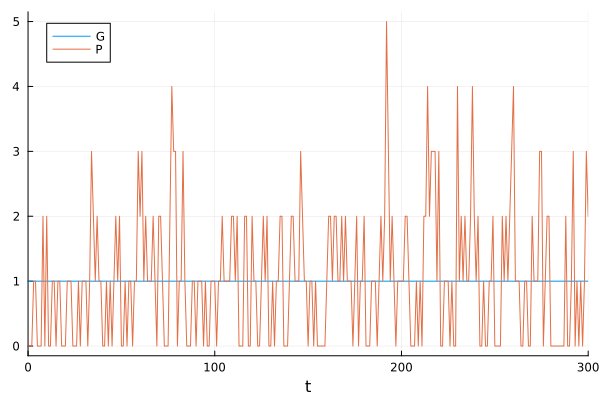

In [8]:
using Plots
plot(sol)

Simulate several trajectories

In [9]:
# simulate several trajectories
@time begin
# dprob_bursty = DiscreteProblem(u0, tspan) # no need for this line? 
traj = 100
bursty_jinput = JumpInputs(bursty_model, u0, tspan, params)
bursty_jprob = JumpProblem(bursty_jinput, save_positions=(false, false))
bursty_eprob = EnsembleProblem(bursty_jprob)
bursty_esol = solve(bursty_eprob, SSAStepper(), saveat=1.0, trajectories=traj)
# plot(bursty_esol)
# plot([w[1] for w in bursty_esol.u[1000].u])
end

  0.789811 seconds (2.20 M allocations: 113.339 MiB, 98.99% compilation time: 4% of which was recompilation)


EnsembleSolution Solution of length 100 with uType:
ODESolution{Int64, 2, Vector{Vector{Int64}}, Nothing, Nothing, Vector{Float64}, Nothing, Nothing, DiscreteProblem{Vector{Int64}, Tuple{Float64, Float64}, true, MTKParameters{Vector{Float64}, StaticArraysCore.SizedVector{0, Float64, Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, DiscreteFunction{true, true, DiscreteFunction{true, SciMLBase.FullSpecialize, SciMLBase.var"#236#237", Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Nothing, ModelingToolkit.ObservedFunctionCache{JumpSystem{ArrayPartition{Any, Tuple{Vector{MassActionJump}, Vector{ConstantRateJump}, Vector{VariableRateJump}, Vector{Equation}}}}}, JumpSystem{ArrayPartition{Any, Tuple{Vector{MassActionJump}, Vector{ConstantRateJump}, Vector{VariableRateJump}, Vector{Equation}}}}, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}, SSAStepper, SciMLBase.ConstantInterpolation{Vector{Float64}, Vector{Vector{Int64}}}, SciMLBase.DEStats, Nothing, N

Use the modularised code from BurstySSA.jl


In [2]:
using Pkg
Pkg.activate(".")

include("/home/ianyang/stochastic_simulations/julia/simulation/BurstySSA.jl")
using .BurstySSA

  Activating project at `~/stochastic_simulations/julia`


In [ ]:
# run simulations for two conditions
parameter_sets = [
    Dict("k"=>0.02, 
    "b"=>10, # b must be >1: Geometric distribution expects a probability parameter p where 0 < p ≤ 1, and Geometric(1/b) is used. 
    "d"=>1, "label"=>0)
]

# Save times
time_points = collect(0.0:1.0:100.0)  # 0,1,2,...,100

# Run 500 trajectories per condition using all available threads
df = simulate_bursty_model(parameter_sets, time_points, 500)

println(first(df, 5))
println(size(df))  # Should be (1000, 102) for 2 conditions and 101 time points each

5×102 DataFrame
 Row │ label  time_0.0  time_1.0  time_2.0  time_3.0  time_4.0  time_5.0  time_6.0  time_7.0  time_8.0  time_9.0  time_10.0  time_11.0  time_12.0  time_13.0  time_14.0  time_15.0  time_16.0  time_17.0  time_18.0  time_19.0  time_20.0  time_21.0  time_22.0  time_23.0  time_24.0  time_25.0  time_26.0  time_27.0  time_28.0  time_29.0  time_30.0  time_31.0  time_32.0  time_33.0  time_34.0  time_35.0  time_36.0  time_37.0  time_38.0  time_39.0  time_40.0  time_41.0  time_42.0  time_43.0  time_44.0  time_45.0  time_46.0  time_47.0  time_48.0  time_49.0  time_50.0  time_51.0  time_52.0  time_53.0  time_54.0  time_55.0  time_56.0  time_57.0  time_58.0  time_59.0  time_60.0  time_61.0  time_62.0  time_63.0  time_64.0  time_65.0  time_66.0  time_67.0  time_68.0  time_69.0  time_70.0  time_71.0  time_72.0  time_73.0  time_74.0  time_75.0  time_76.0  time_77.0  time_78.0  time_79.0  time_80.0  time_81.0  time_82.0  time_83.0  time_84.0  time_85.0  time_86.0  time_87.0  time_88.0  t